In [39]:
from pandas import *
import sys
path = '/Users/jplotkin/Dropbox/school/adv_ml'
path += '/project/scripts_notebooks'
sys.path.append(path)

from prep_datasets import *
from train_cv_predict import *
plt.style.use('ggplot')

%load_ext autotime
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 26.3 ms


### Load data
* image features from CNN
* metadata

In [2]:
data_path = '../boots_dataset/'
metadata_women = read_csv(data_path + 'boots_aws_metadata_160405.csv',
                         index_col = 'asin')
metadata_women = metadata_women[metadata_women.sex == 'women']
features_women = read_csv(data_path + 'features_women.csv',
                         index_col = 'asin')

time: 3.97 s


In [3]:
path = '/Users/jplotkin/Dropbox/school/adv_ml/'
path += 'project/ImageRec/data/test_likes_josh.txt'
likes_dislikes = read_csv(path, 
                 header = None)\
                    .drop_duplicates()\
                    .set_index(0, inplace = False)
likes_dislikes.index.name = 'asin'
likes_dislikes.columns = ['like']

time: 24.8 ms


In [4]:
likes_dislikes.merge(metadata_women, left_index = True, 
                    right_index = True).merge(features_women, left_index = True, 
                           right_index = True).like.value_counts()

0    127
1     33
Name: like, dtype: int64

time: 43.8 ms


In [5]:
likes = likes_dislikes.merge(metadata_women, left_index = True, 
                    right_index = True).merge(features_women, left_index = True, 
                           right_index = True).like

time: 38.2 ms


### PrepData class
* balance dataset by oversampling
* perform stratified sampling to split data
* takes list of size of training set (the rest go into test)
* creates a feature set of unlabeled data (for recommendations)

In [6]:
dataset = PrepData(DataFrame(likes), features_women, 
                   [10, 25, 50, 80], 5, False)

10 0.9375
10 150
10 150
10 150
10 150
10 150
25 0.84375
25 135
25 135
25 135
25 135
25 135
50 0.6875
50 110
50 110
50 110
50 110
50 110
80 0.5
80 80
80 80
80 80
80 80
80 80
time: 16.4 s


In [7]:
print dataset.training_sets.keys()
print dataset.test_sets.keys()

[80, 25, 10, 50]
[80, 25, 10, 50]
time: 17.1 ms


In [8]:
dataset.training_sets[50][0].like.value_counts()

0    40
1    10
Name: like, dtype: int64

time: 20.6 ms


In [9]:
dataset.training_sets[50][0].drop_duplicates().like.value_counts()

0    40
1    10
Name: like, dtype: int64

time: 194 ms


In [10]:
dataset.test_sets[50][0].like.value_counts()

0    87
1    23
Name: like, dtype: int64

time: 19.1 ms


In [11]:
dataset.test_sets[50][0].drop_duplicates().like.value_counts()

0    87
1    23
Name: like, dtype: int64

time: 208 ms


In [12]:
asin_in = []
for asin in dataset.test_sets[50][0].index:
    asin_in.append(asin in dataset.training_sets[50][0])
print sum(asin_in)

0
time: 17.2 ms


### TrainModel class
TrainModel(train, test, algo, grid params, nfolds)
* performs grid search automatically using params and number of folds
* returns best model
* include methods to get AUC, plot ROC, and show top n recommendations
* TODO: implement XGBoost grid search 

In [13]:
training_set = dataset.training_sets[80][0]
test_set = dataset.test_sets[80][0]
unlabeled = dataset.unlabeled

time: 19.2 ms


### XGBoost:

[0]	train-auc:0.986328
[1]	train-auc:1.000000
[2]	train-auc:1.000000
[3]	train-auc:1.000000
[4]	train-auc:1.000000
[5]	train-auc:1.000000
[6]	train-auc:1.000000
[7]	train-auc:1.000000
[8]	train-auc:1.000000
[9]	train-auc:1.000000


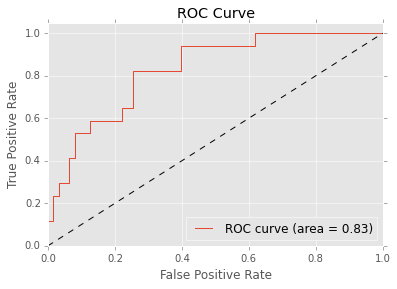

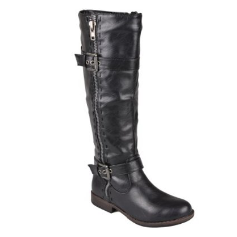

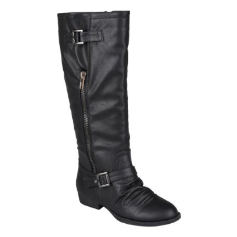

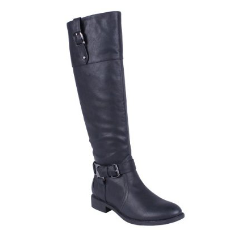

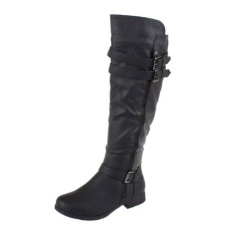

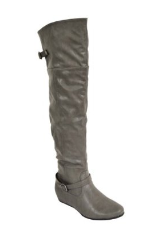

time: 2.29 s


In [40]:
param = {'bst:max_depth':150, 
         'bst:eta':0.3, 
         'silent':1,
         'objective':'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['eval_metric'] = ['auc']
model = TrainModel(training_set.copy(), test_set.copy(), 
                   'xgb_no_cv', param, 5)
model.get_auc()
model.plot_roc()
model.display_recommendations(unlabeled.copy(), 5)

In [41]:
import operator
importance = model.model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
importance_df = DataFrame(importance, columns=['feature', 'fscore'])
importance_df['fscore'] = \
    importance_df['fscore'] / importance_df['fscore'].sum()
important_features = importance_df\
            .sort_values('fscore', ascending = False)\
            .iloc[:5, :].values
        
standardized = unlabeled.copy()
for c in standardized.columns:
    standardized.loc[:, c] = (standardized.loc[:, c] -
                              standardized.loc[:, c].mean()) \
                             / standardized.loc[:, c].std()        

time: 2.54 s


In [42]:
def display_images(asin, n):
    img = '../boots_dataset/pics_boots/{0}.jpg'.format(asin)
    if os.path.isfile(img) and open(img).read() != '':
        ax = fig.add_subplot(2,4,n)
        ax.grid(False)
        for label in ax.get_xticklines():
            label.set_visible(False)
        for label in ax.get_yticklines():
            label.set_visible(False)
        for label in ax.get_xticklabels():
            label.set_visible(False)
        for label in ax.get_yticklabels():
            label.set_visible(False)  

        ax.imshow(mpimg.imread(img))
        return True
    else:
        # skip if the image is not found
        return False

time: 23.7 ms


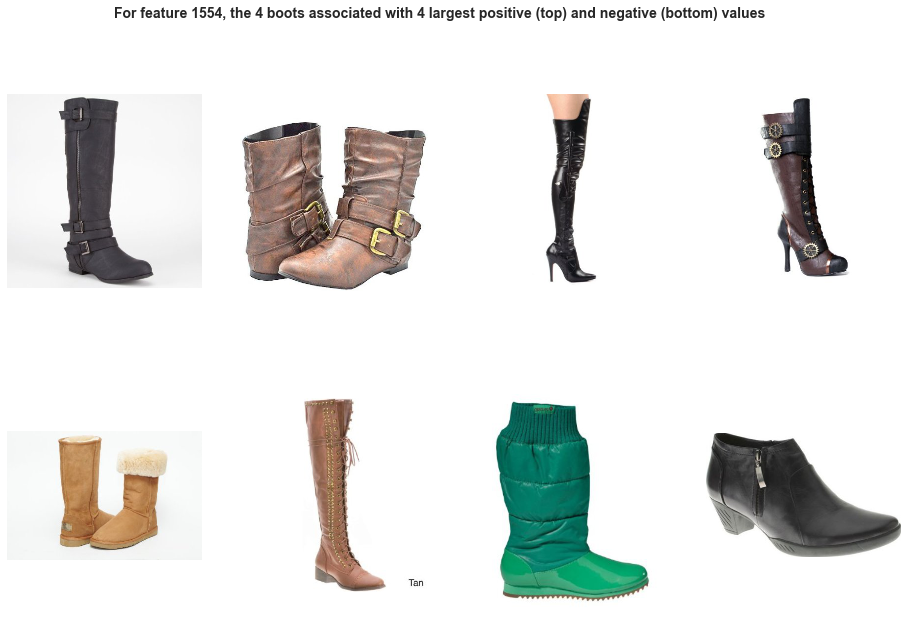

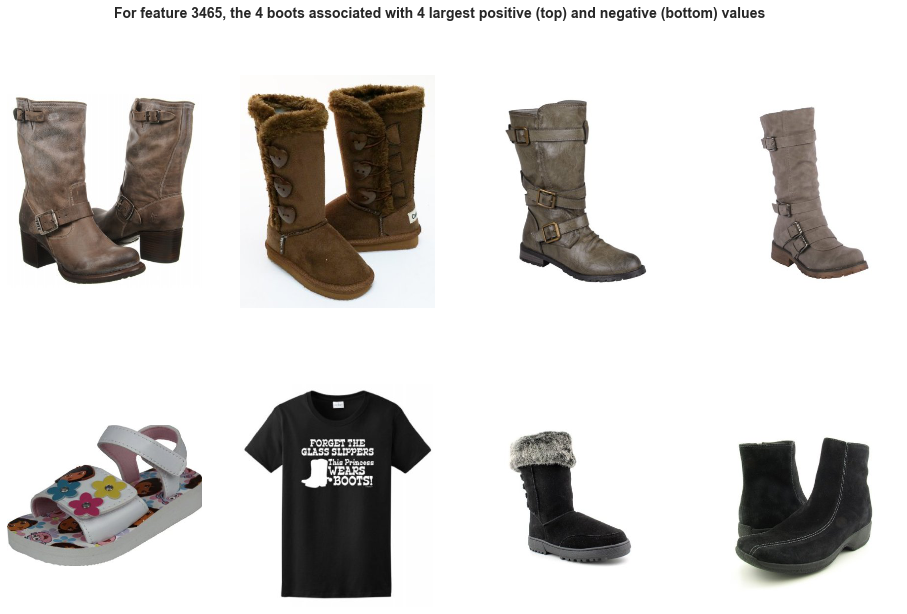

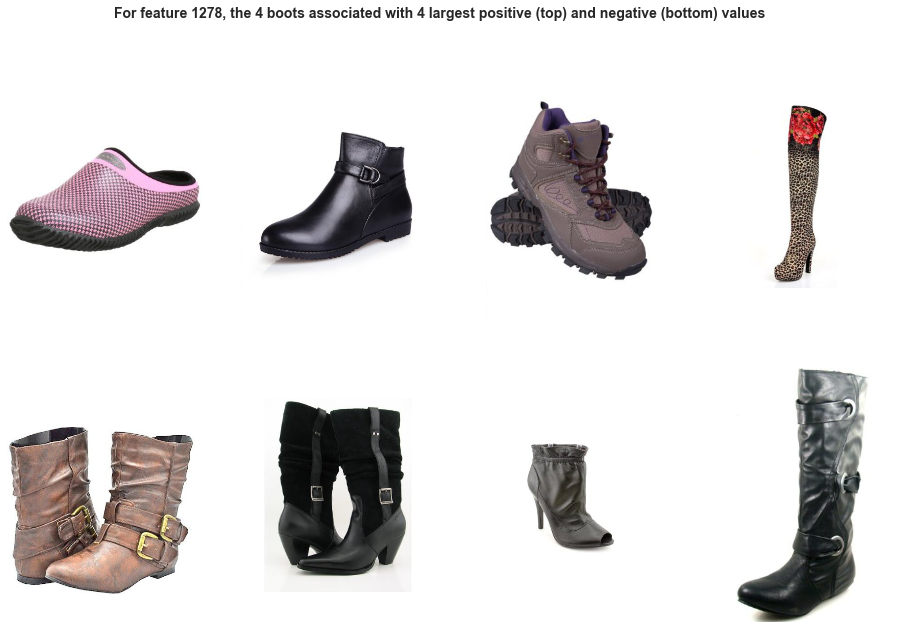

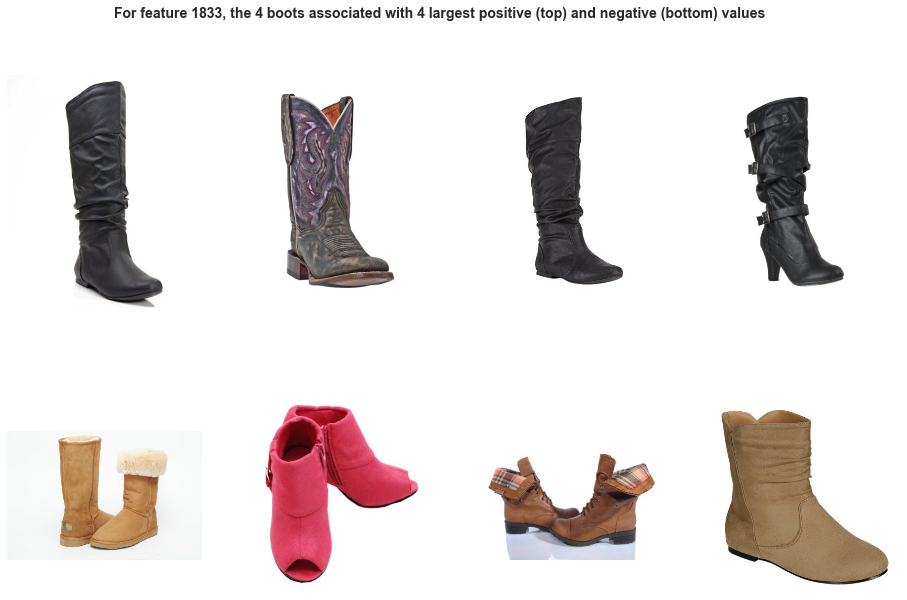

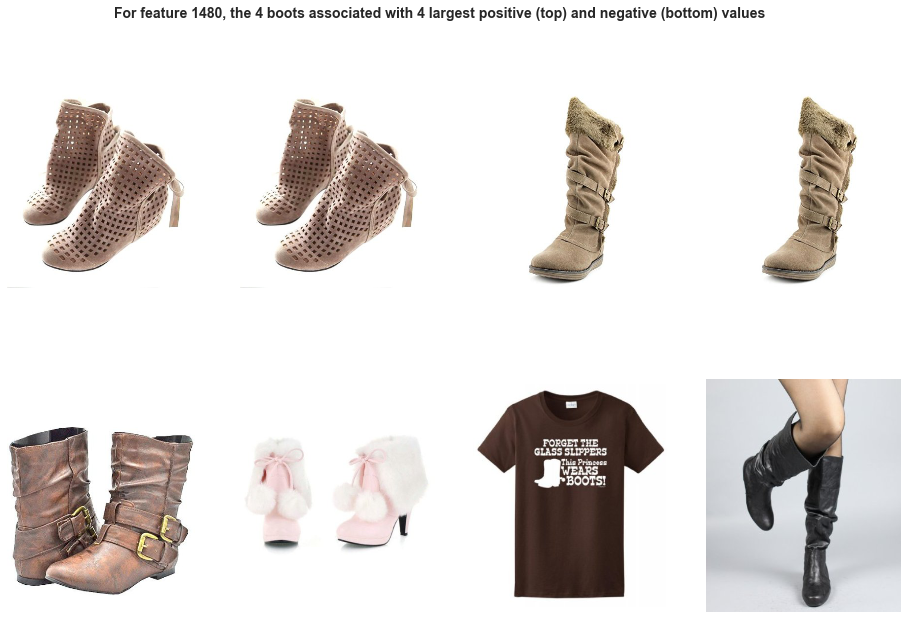

time: 6.2 s


In [43]:
import seaborn as sns
for feature in [f[0] for f in important_features]:
    order = standardized.sort_values(by = str(feature),
                                    ascending = False)\
                        .index
        
    with sns.axes_style("white"):    
        fig = plt.figure(figsize = (16,10))
        title = 'For feature {0}, '.format(feature)
        title += 'the 4 boots associated with 4 largest positive (top) '
        title += 'and negative (bottom) values'
        plt.suptitle(title, fontsize = 14, fontweight = 'bold') 

    loc = 1
    for top_bottom in [1, -1]:
        n = 1
        while n <= 4:
            found = display_images(order[n*top_bottom], loc)
            if found == True:
                n += 1
                loc += 1
            # skip over this image if it can't be found
            else:
                pass
        
    plt.savefig('features_{0}.jpg'.format(feature))
    plt.show()

### SVM:

0.666199813259
Model with rank: 1
Mean validation score: 0.850 (std: 0.053)
Parameters: {'kernel': 'rbf', 'C': 15.848931924610072, 'gamma': 0.0001, 'class_weight': {0: 0.5, 1: 0.5}}

Model with rank: 2
Mean validation score: 0.850 (std: 0.053)
Parameters: {'kernel': 'rbf', 'C': 19.95262314968744, 'gamma': 0.0001, 'class_weight': {0: 0.5, 1: 0.5}}

Model with rank: 3
Mean validation score: 0.850 (std: 0.053)
Parameters: {'kernel': 'rbf', 'C': 25.118864315094076, 'gamma': 0.0001, 'class_weight': {0: 0.5, 1: 0.5}}



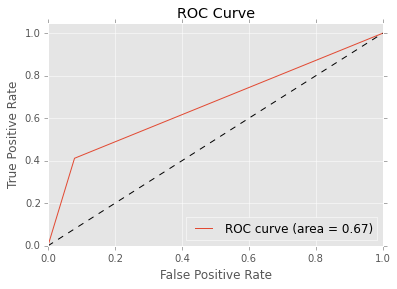

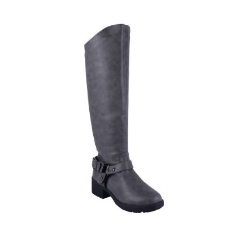

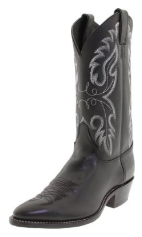

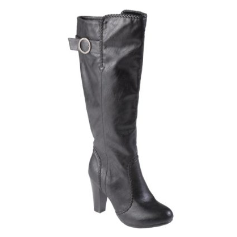

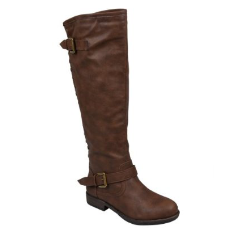

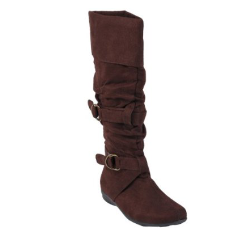

time: 4min 40s


In [16]:
param_grid = [
  {'C': [10**i for i in np.arange(-7,2,.1)], 
       'kernel': ['linear'], 
       'class_weight': [{1: 0.75, 0: 0.25}, {1: 0.90, 0: 0.10}, {1: 0.50, 0: 0.50}]
},
  {'C': [10**i for i in np.arange(-7,2,.1)], 
       'gamma': [0.001, 0.0001], 'kernel': ['rbf'],
       'class_weight': [{1: 0.75, 0: 0.25}, {1: 0.90, 0: 0.10}, {1: 0.50, 0: 0.50}]
},
 ]
svm = TrainModel(training_set.copy(), test_set.copy(), 
                   'svm', param_grid, 10)

print svm.get_auc()
svm.report()
svm.plot_roc()

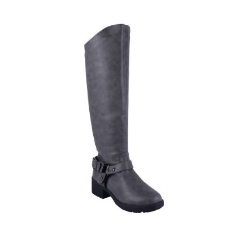

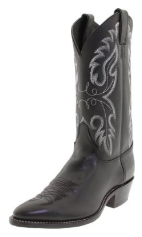

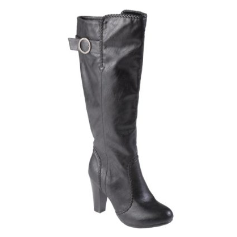

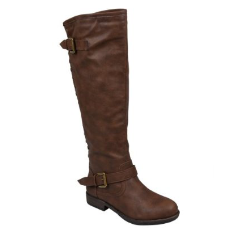

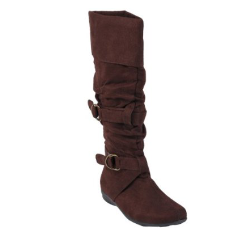

time: 645 ms


In [28]:
svm.model.fit(training_set.drop('like', axis = 1), training_set.like)
svm.display_recommendations(unlabeled.copy(), 10)

### Naive Bayes

Model with rank: 1
Mean validation score: 0.850 (std: 0.051)
Parameters: {'alpha': 0.00099999999999996728}

Model with rank: 2
Mean validation score: 0.850 (std: 0.061)
Parameters: {'alpha': 0.0063095734448016848}

Model with rank: 3
Mean validation score: 0.850 (std: 0.061)
Parameters: {'alpha': 0.0079432823472424963}



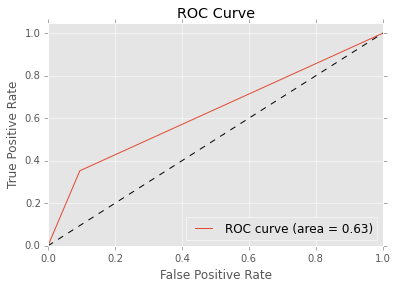

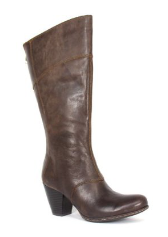

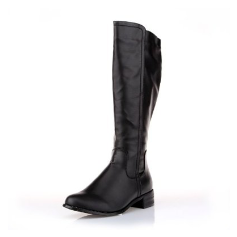

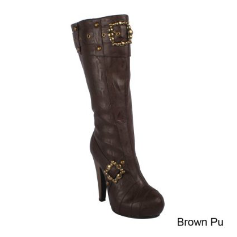

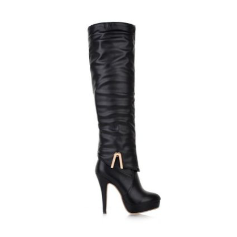

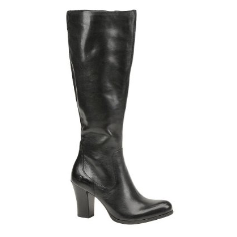

time: 4.87 s


In [17]:
param_grid = [
  {'alpha': [10**i for i in np.arange(-7,2,.1)]}
 ]    
nb = TrainModel(training_set.copy(), test_set.copy(),
                   'nb', param_grid, 10)
nb.get_auc()
nb.report()
nb.plot_roc()

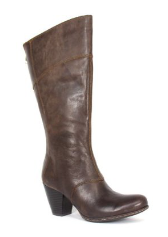

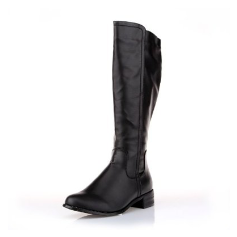

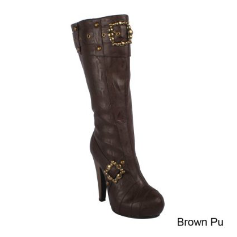

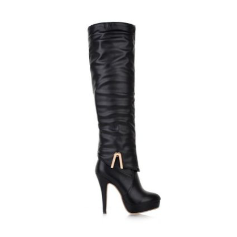

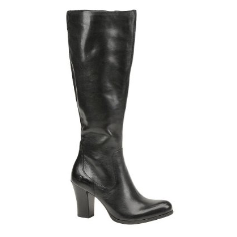

time: 508 ms


In [29]:
nb.model.fit(training_set.drop('like', axis = 1), training_set.like)
nb.display_recommendations(unlabeled.copy(), 10)

### Random Forest

Model with rank: 1
Mean validation score: 0.875 (std: 0.071)
Parameters: {'bootstrap': True, 'min_samples_leaf': 10, 'min_samples_split': 1, 'criterion': 'entropy', 'max_features': 1601, 'max_depth': 4000}

Model with rank: 2
Mean validation score: 0.838 (std: 0.064)
Parameters: {'bootstrap': False, 'min_samples_leaf': 5, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 3401, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.838 (std: 0.066)
Parameters: {'bootstrap': False, 'min_samples_leaf': 5, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 1201, 'max_depth': 4000}



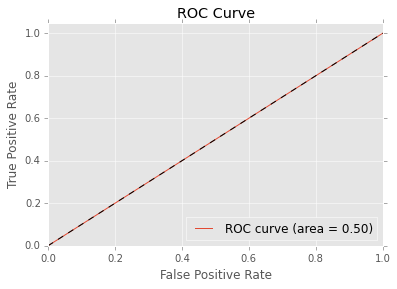

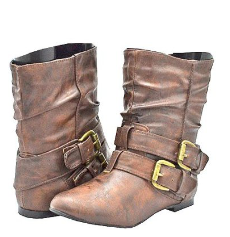

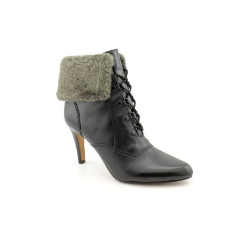

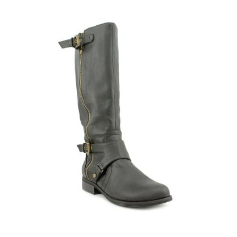

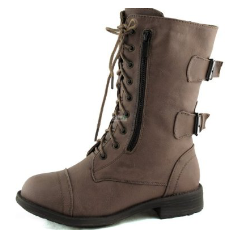

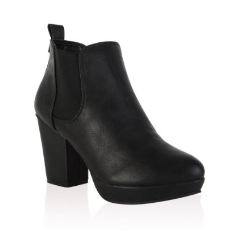

time: 2min 20s


In [18]:
param_grid = {"max_depth": [3, 4000],
              "max_features": np.arange(1,4000,200),
              "min_samples_split": np.arange(1,500,100),
              "min_samples_leaf": [100, 50, 25, 10, 5],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rf = TrainModel(training_set.copy(), test_set.copy(),
                   'rf', param_grid, 10)

rf.get_auc()
rf.report()
rf.plot_roc()

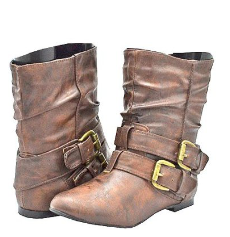

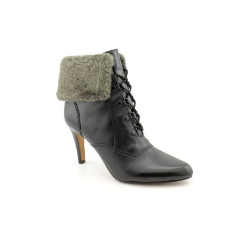

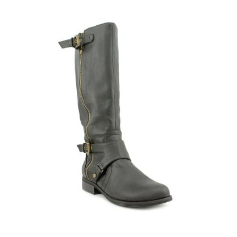

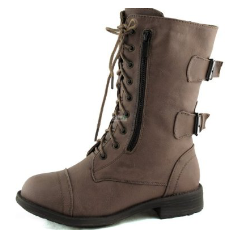

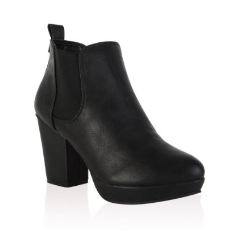

time: 543 ms


In [30]:
rf.model.fit(training_set.drop('like', axis = 1), training_set.like)
rf.display_recommendations(unlabeled.copy(), 10)

### Elastic Net logistic regression

Model with rank: 1
Mean validation score: 0.713 (std: 0.188)
Parameters: {'alpha': 10, 'l1_ratio': 1.0}

Model with rank: 2
Mean validation score: 0.662 (std: 0.141)
Parameters: {'alpha': 0.01, 'l1_ratio': 0.70000000000000007}

Model with rank: 3
Mean validation score: 0.650 (std: 0.182)
Parameters: {'alpha': 1.0000000000000001e-05, 'l1_ratio': 0.80000000000000004}



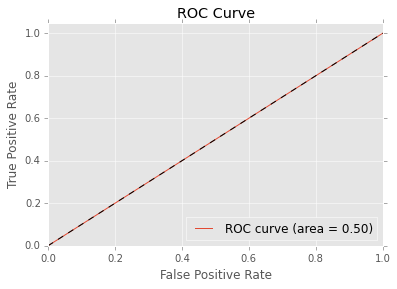

time: 10.6 s


In [36]:
param_grid = [
        {'alpha': [10**i for i in np.arange(-7,2,1)], 
         'l1_ratio': np.arange(0,1.1,0.1)
        }]

enet = TrainModel(training_set.copy(), test_set.copy(),
                   'lr_enet', param_grid, 10)

enet.get_auc()
enet.report()
enet.plot_roc()

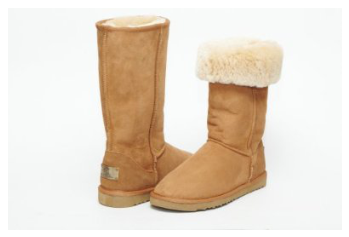

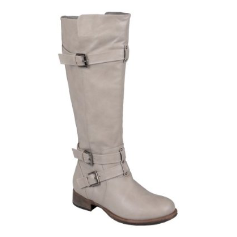

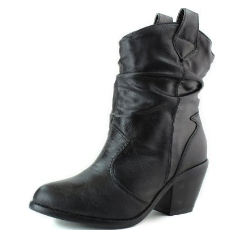

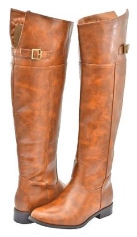

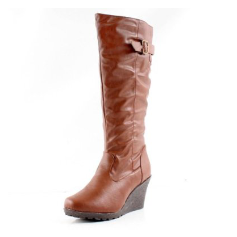

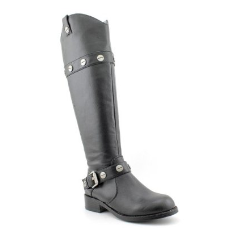

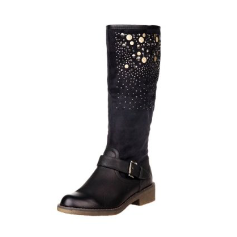

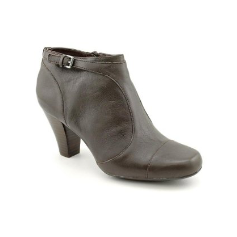

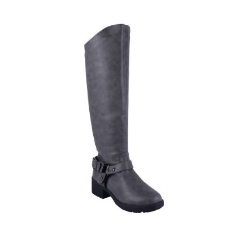

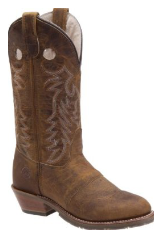

time: 2.28 s


In [37]:
enet.model.fit(training_set.drop('like', axis = 1), training_set.like)
enet.display_recommendations(unlabeled.copy(), 10)

### Scikit-learn SGD Classifier

Model with rank: 1
Mean validation score: 0.863 (std: 0.031)
Parameters: {'alpha': 1.5848931924611109e-07, 'l1_ratio': 0.20000000000000001, 'loss': 'squared_hinge', 'class_weight': {0: 0.5, 1: 0.5}}

Model with rank: 2
Mean validation score: 0.863 (std: 0.050)
Parameters: {'alpha': 5.0118723362726943e-07, 'l1_ratio': 0.10000000000000001, 'loss': 'perceptron', 'class_weight': {0: 0.25, 1: 0.75}}

Model with rank: 3
Mean validation score: 0.863 (std: 0.050)
Parameters: {'alpha': 1.2589254117941559e-06, 'l1_ratio': 0.60000000000000009, 'loss': 'hinge', 'class_weight': {0: 0.5, 1: 0.5}}



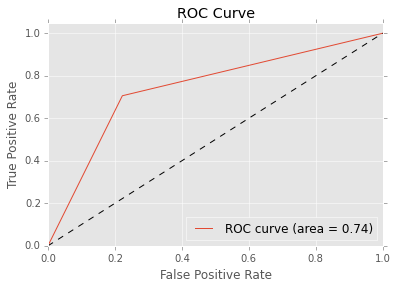

time: 14min 48s


In [33]:
param_grid = [
        {'alpha': [10**i for i in np.arange(-7,2,.1)], 
         'l1_ratio': np.arange(0,1.1,0.1),
         'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
         'class_weight': [{1: 0.75, 0: 0.25}, {1: 0.90, 0: 0.10}, {1: 0.50, 0: 0.50}]
        }]

sgd = TrainModel(training_set.copy(), test_set.copy(),
                   'sgd', param_grid, 2)
sgd.get_auc()
sgd.report()
sgd.plot_roc()

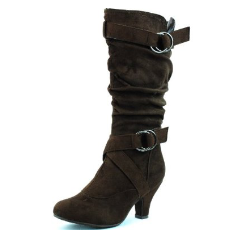

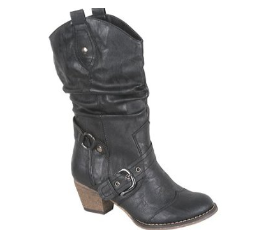

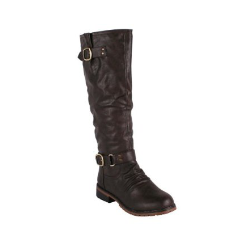

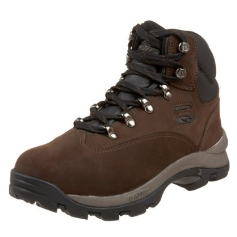

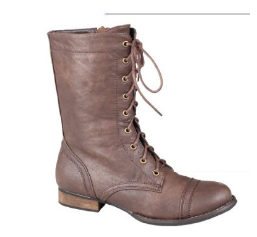

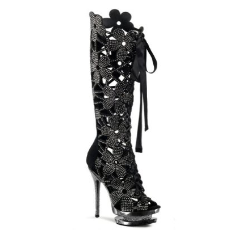

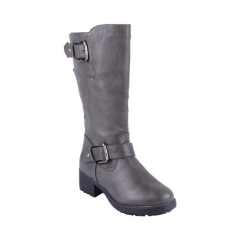

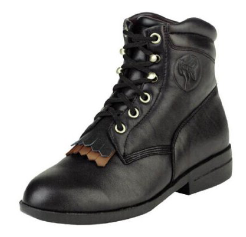

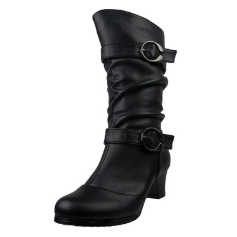

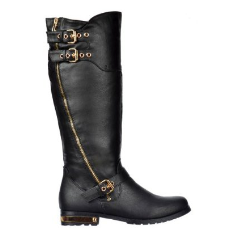

time: 1.44 s


In [34]:
sgd.model.fit(training_set.drop('like', axis = 1), training_set.like)
sgd.display_recommendations(unlabeled.copy(), 10)

### Comparison of Online vs. Batch Learning for Scikit-Learn's SGDClassifier

#### Train in batch

In [21]:
model = SGDClassifier(alpha = 1e-6, l1_ratio = .1, loss = 'hinge', penalty='elasticnet', 
        class_weight={1: 0.75, 0: 0.25})

model.fit(training_set.drop('like', axis = 1), training_set.like)

pred_df = DataFrame(zip(model.predict(test_set.drop('like', axis = 1)), test_set.like))
pred_df.columns = 'predicted','actual'
fpr, tpr, _ = roc_curve(pred_df.actual, 
                        pred_df.predicted, 
                        pos_label = 1)
roc_auc = auc(fpr, tpr)
print roc_auc

0.745098039216
time: 40.5 ms


#### Train incrementally (one)

In [22]:
training_set.iloc[0, :].drop('like').values.reshape(-1, 1).shape

(4096, 1)

time: 25.6 ms


In [23]:
model = SGDClassifier(alpha = 1e-6, l1_ratio = .1, loss = 'hinge', penalty='elasticnet', 
        class_weight={1: 0.75, 0: 0.25})

model.partial_fit(training_set.iloc[0, :].drop('like').values.reshape(1, -1), 
                  np.array(int(training_set.iloc[0, :].like)).reshape(-1, ),
                 [0, 1])

SGDClassifier(alpha=1e-06, average=False, class_weight={0: 0.25, 1: 0.75},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.1,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

time: 27.9 ms


#### Train incrementally (all)

In [44]:
model = SGDClassifier(alpha = 1e-6, l1_ratio = .1, loss = 'hinge', penalty='elasticnet', 
        class_weight={1: 0.75, 0: 0.25})

non_like = [c for c in training_set.columns if c != 'like']
for n, i in enumerate(training_set.index):
    if n == 0:
        # include class weights on first call of partial_fit
        model.partial_fit(training_set.loc[i, :].drop('like').values.reshape(1, -1), 
                          np.array(int(training_set.loc[i, :].like)).reshape(-1, ),
                         [0, 1])
    else:
        model.partial_fit(training_set.loc[i, :].drop('like').values.reshape(1, -1), 
                          np.array(int(training_set.loc[i, :].like)).reshape(-1, ))
        
        
pred_df = DataFrame(zip(model.predict(test_set.drop('like', axis = 1)), test_set.like))
pred_df.columns = 'predicted','actual'
fpr, tpr, _ = roc_curve(pred_df.actual, 
                        pred_df.predicted, 
                        pos_label = 1)
roc_auc = auc(fpr, tpr)
print roc_auc

0.737161531279
time: 558 ms


In [25]:
np.nonzero(model.coef_[0])

(array([   1,    2,    4, ..., 4093, 4094, 4095]),)

time: 20.1 ms
